In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import math

In [ ]:

#lo mismo de la otra conf. de entrenamiento
loss_tracker = keras.metrics.Mean(name="loss")
class Solpol(Sequential):
    @property
    def metrics(self):
        return [loss_tracker] #igual cambia el loss_tracker

    def train_step(self, data):
        batch_size =50 #Calibra la resolucion
        x = tf.random.uniform((batch_size,1), minval=-1, maxval=1)
        f = tf.math.sin(2.*x)


        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            #loss = keras.losses.mean_squared_error(y_pred,f)
            mse = tf.keras.losses.MeanSquaredError(
                reduction=tf.keras.losses.Reduction.SUM)
            loss= mse(f, y_pred)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #actualiza metricas
        loss_tracker.update_state(loss)

        return {"loss": loss_tracker.result()}

In [ ]:
class Ajuspol(tf.keras.layers.Layer):
    def __init__(self, num_outputs):
        super(Ajuspol,self).__init__() #heredar todas las propiedades de una capa en keras
        self.num_outputs = num_outputs #definir la propiedad de neuronas de salida
        self.elv =tf.range(0.,self.num_outputs)
        self.coefs = self.add_weight("coefs",
                                shape=[self.num_outputs])#crear una instancia para variables de entrenamiento, crea pesos para ser entrenados en la red
                                #modifica los coef. de un polinomio

#metodo para definir como se tratan las entradas para calcular las salidas de la capa
    def call(self, inputs):
        inputs = tf.convert_to_tensor(inputs) #convienrte la entrada en un tensor
        #convertir a formato de tensorflow
        if (inputs.shape == ()):
            inputs=(inputs,)
        elif (len(inputs.shape)==1):
            inputs=tf.expand_dims(inputs, axis=1)

        #calculo de las salidas

        # Elevar x para que quede en forma de polinomio de 3er grado
        batch= tf.shape(inputs)[0] #calcular el tamaño del batch
        self.elev_b=tf.ones([batch,1])*self.elv #darle forma a las elevaciones como (batch,num_outputs)
        inputs_b= tf.tile(inputs,[1,self.num_outputs])#copiar las columnas de los inputs en un tensor de (batch,num_outputs)
        x_elv= tf.pow(inputs_b,self.elev_b) #elevar elemento a elemento los numeros de ambos tensores
#salida (batch,num:outputs)
        # calcular el producto escalar de las x elevadas y los coef., así tendremos
        # un tensor de tamaño (batch,1) ya que estamos haciendo la multiplicación en el
        # canal de los num_outputs
        pol= tf.tensordot(x_elv,self.coefs, 1)
        return tf.expand_dims(pol, axis=1) #la respuesta res se le da formato de tensor de tensorflow para que sea compatible con la arquitectura de tensorgflow y keras
        #así la salida de la capa es (batch,1,1)

In [ ]:
#arquitectura de la red
modelo=Solpol() #crear instancia del entrenamiento
modelo.add(Ajuspol(4)) #establecer la capa del polinomio para pol de 3er grado (4 coef o parámetros entranables)
modelo.build(input_shape=(1,))#inicializar la red y darle la entrada corrspondiente a input_shape
modelo.summary()

Model: "solpol_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ajuspol_8 (Ajuspol)         (1, 1)                    4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#crear arquitectura
modelo.compile(optimizer=Adam(learning_rate=0.01), metrics=['loss']) #compilar la red
x=tf.linspace(-1,1,100) #crear la base de datos (las entradas)
history2 =modelo.fit(x,epochs=500,verbose=1) #entrenar la red i guardarla en history2

Epoch 1/500
4/4 [==============================] - 0s 7ms/step - loss: 44.2859
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 39.9547
Epoch 3/500
4/4 [==============================] - 0s 4ms/step - loss: 36.0958
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 29.0750
Epoch 5/500
4/4 [==============================] - 0s 4ms/step - loss: 23.5998
Epoch 6/500
4/4 [==============================] - 0s 5ms/step - loss: 24.4965
Epoch 7/500
4/4 [==============================] - 0s 5ms/step - loss: 22.8496
Epoch 8/500
4/4 [==============================] - 0s 4ms/step - loss: 15.8092
Epoch 9/500
4/4 [==============================] - 0s 4ms/step - loss: 15.1904
Epoch 10/500
4/4 [==============================] - 0s 4ms/step - loss: 14.2887
Epoch 11/500
4/4 [==============================] - 0s 4ms/step - loss: 10.9952
Epoch 12/500
4/4 [==============================] - 0s 3ms/step - loss: 9.4895
Epoch 13/500
4/4 [==============================] 

[<tf.Variable 'coefs:0' shape=(4,) dtype=float32, numpy=
array([ 3.5806085e-04,  1.9449257e+00, -9.8380737e-04, -1.0621221e+00],
      dtype=float32)>]


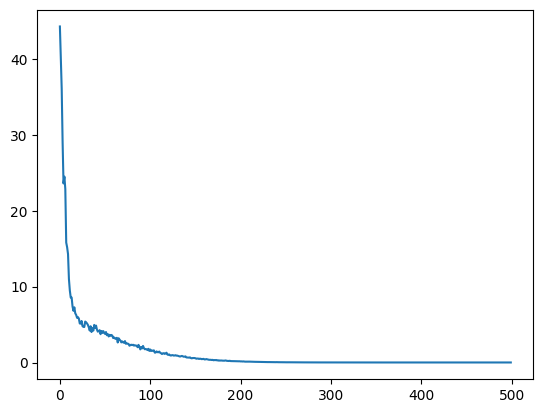

In [ ]:
#ver el valor de los coef.
print(modelo.layers[0].trainable_weights) #mostrar los pesos
plt.plot(history2.history["loss"]) #graficar el costo

4/4 [==============================] - 0s 3ms/step


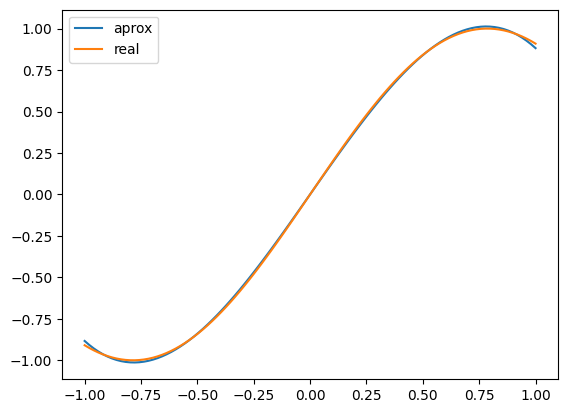

In [ ]:
a=modelo.predict(x) #usar la red ya entrenada para predecir el comportamiento de esos datos
plt.plot(x,a,label="aprox") #graficar las predicciones
plt.plot(x, tf.math.sin(2.*x), label="real") #graf real
plt.legend()
plt.show()

YA QUEDOOOOOO